In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
%matplotlib inline

In [2]:
(x_train_orig,y_train_orig),(x_test_orig,y_test_orig) = tf.keras.datasets.mnist.load_data()

Index :0 Lable:5


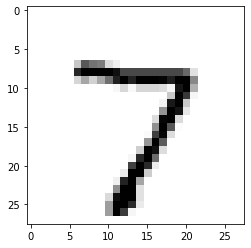

In [3]:
index = 0
print("Index :{i} Lable:{l}".format(i=index,l=y_train_orig[index]))
plt.imshow(x_test_orig[index],cmap='Greys')

In [4]:
x_train = x_train_orig.reshape((x_train_orig.shape[0],-1)).T
y_train = y_train_orig.reshape((y_train_orig.shape[0],1)).T

x_test = x_test_orig.reshape((x_test_orig.shape[0],-1)).T
y_test = y_test_orig.reshape((y_test_orig.shape[0],1)).T

print("x_train shape :",x_train.shape)
print("y_train shape :",y_train.shape)
print("x_test shape :",x_test.shape)
print("y_test shape :",y_test.shape)

x_train shape : (784, 60000)
y_train shape : (1, 60000)
x_test shape : (784, 10000)
y_test shape : (1, 10000)


In [5]:
x_train_flatten = x_train/255
x_test_flatten = x_test/255

In [6]:
def initialize_parameters(layers_dims):
    parameters = {}
    for l,L in enumerate(layers_dims[:-1]):
        parameters['W'+str(l+1)] = tf.get_variable(dtype=tf.float32,shape=(layers_dims[l+1],layers_dims[l]),initializer=tf.contrib.layers.xavier_initializer(),name='W'+str(l+1))
        parameters['b'+str(l+1)] = tf.zeros(dtype=tf.float32,shape=(layers_dims[l+1],1),name='b'+str(l+1))
    return parameters

In [7]:
test_dims = [1020,12,10,5,3,2]
print(test_dims)
for l,L in enumerate(test_dims[:-1]):
    print("W{n} : ({x},{y})".format(n=l+1,x=test_dims[l+1],y=test_dims[l]))

[1020, 12, 10, 5, 3, 2]
W1 : (12,1020)
W2 : (10,12)
W3 : (5,10)
W4 : (3,5)
W5 : (2,3)


In [8]:
def shuffle(X,Y,batch_size):
    m = X.shape[1]
    num_batches = int(m/batch_size)
    if (m%batch_size != 0):
        num_batches = num_batches+1
    indecies = np.arange(X.shape[1])
    np.random.shuffle(indecies)
    X_shuffled = X[:,indecies]
    Y_shuffled = Y[:,indecies]
    return (X_shuffled,Y_shuffled,num_batches)

In [9]:
def get_batch(t,X,Y,batch_size):
    m = X.shape[1]
    i = t*batch_size
    num_batches = int(m/batch_size)
    if(t<num_batches):
        batch = (X[:,i:i+batch_size],Y[:,i:i+batch_size])
    else:
        batch = (X[:,i:],Y[:,i:])
    return batch

In [10]:
def forward_prop(X,parameters,layers_dims):
    for l,L in enumerate(layers_dims[:-2]):
        if(l==0):
            Z = tf.matmul(parameters['W1'],X)+parameters['b1']
            A = tf.nn.relu(Z)
        else:
            Z = tf.matmul(parameters['W'+str(l+1)],A)+parameters['b'+str(l+1)]
            A = tf.nn.relu(Z)
    Z = tf.matmul(parameters['W'+str(len(layers_dims)-1)],A)+parameters['b'+str(len(layers_dims)-1)]
    return Z

In [11]:
for l,L in enumerate(test_dims[:-2]):
        if(l==0):
#             Z = tf.add(tf.matmul(parameters['W1'],X),parameters['b1'])
            print('W1 b1')
#             A = tf.nn.relu(Z)
        else:
#             Z = tf.add(tf.matmul(parameters['W'+str(l+1)],A),parameters['b'+str(l+1)])
            print('W{i} b{i}'.format(i=l+1))
#             A = tf.nn.relu(Z)
print('W{i} b{i}'.format(i=len(test_dims)-1))

W1 b1
W2 b2
W3 b3
W4 b4
W5 b5


In [12]:
def compute_cost(Z,Y):
    logits = tf.transpose(Z)
    labels = tf.transpose(Y)
    cost = cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    return cost

In [13]:
def placeholders(n_x,n_y):
    x_pl = tf.placeholder(dtype=tf.float32,shape=[n_x,None])
    y_pl = tf.placeholder(dtype=tf.float32,shape=[n_y,None])
    return x_pl, y_pl

In [14]:
def one_hot(lables,C):
    with tf.compat.v1.Session() as sess:
        C = tf.constant(C,name='C')
        one_hot_matrix = tf.one_hot(lables,C,axis =0)
        one_hot = sess.run(one_hot_matrix)
    
    return one_hot

In [15]:
def model(X_train, Y_train, X_test, Y_test,layers_dims ,batchsize=256 ,epochs=1500 ,learning_rate=0.0001):
    ops.reset_default_graph()  
    
    lables = np.unique(Y_train)
    C = len(lables)
    Y_train = one_hot(np.squeeze(Y_train),C)
    Y_test = one_hot(np.squeeze(Y_test),C)
    
    parameters = initialize_parameters(layers_dims)
    
    n_x = X_train.shape[0]
    n_y = Y_train.shape[0]
    X,Y = placeholders(n_x,n_y)
    
    Z_last = forward_prop(X,parameters,layers_dims)
                
    cost = compute_cost(Z_last,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    costs = []
        
    with tf.Session() as sess:
            
        sess.run(tf.global_variables_initializer())
        init_parameters = sess.run(parameters)
        for epoch in range(epochs):
            x,y,num_batches = shuffle(X_train,Y_train,batchsize)
            
            epoch_cost =0
            
            for t in range(num_batches):
                (x_batch,y_batch) = get_batch(t,x,y,batchsize)
                
                _,cost_val = sess.run([optimizer,cost],feed_dict={X:x_batch,Y:y_batch})
                
            epoch_cost += cost_val/x_batch.shape[1]
            
            if epoch%100 == 0 :
                print("Cost after epoch {i} is {c}".format(i=epoch,c=epoch_cost))
            if epoch%5 == 0 :
                costs.append(epoch_cost)
            
        parameters = sess.run(parameters)
        print('Parameters have been trained')
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        correct_prediction = tf.equal(tf.argmax(Z_last,axis =1), tf.argmax(Y,axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
    return parameters

Cost after epoch 0 is 0.08221180737018585
Cost after epoch 100 is 1.8694147001951933e-05
Cost after epoch 200 is 4.264314649541726e-08
Cost after epoch 300 is 6.113079109582031e-08
Cost after epoch 400 is 1.4758545792877461e-08
Cost after epoch 500 is 9.287172512510248e-09
Cost after epoch 600 is 5.988774513336163e-09
Cost after epoch 700 is 6.726212179823202e-10
Cost after epoch 800 is 3.8805036961520045e-10
Cost after epoch 900 is 2.198953796828107e-10
Cost after epoch 1000 is 5.135101233122441e-09
Cost after epoch 1100 is 3.621803967845949e-10
Cost after epoch 1200 is 0.0
Cost after epoch 1300 is 3.880510033675103e-11
Cost after epoch 1400 is 0.0
Parameters have been trained


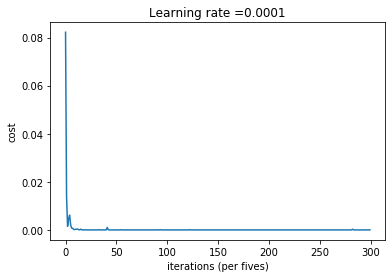

Train Accuracy: 1.0
Test Accuracy: 0.9654


In [31]:
layers_dims = [x_train.shape[0],100,50,10]
parameters = model(x_train,y_train,x_test,y_test,layers_dims)

In [141]:
def predict(X,Y,parameters):
    X_ph = tf.placeholder(dtype=tf.float32,shape=[X.shape[0],None])
    Z_last = forward_prop(X_ph,parameters,layers_dims)
    with tf.Session() as sess:
        Y_prediciton = sess.run(Z_last,feed_dict={X_ph:X})
        Y_prediction = np.argmax(Y_prediciton)
        print(Y_prediction==Y)

True


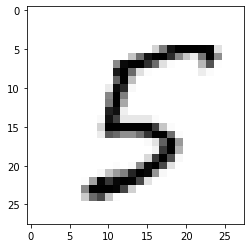

In [142]:
index = 23
input_x = x_test[:,index].reshape(-1,1)
input_y = y_test[0,index]
plt.imshow(x_test[:,index].T.reshape(28,28),cmap='Greys')
predict(input_x, input_y, parameters)

In [213]:
def get_wrong_predictions(X,Y,parameters):
    X_ph = tf.placeholder(dtype=tf.float32,shape=[X.shape[0],None])
    Z_last = forward_prop(X_ph,parameters,layers_dims)
    with tf.Session() as sess:
        
        count=0
        
        for i in range(X.shape[1]):
            test_case = X[:,i].reshape(-1,1)
            Z_p = np.argmax(np.squeeze(sess.run(Z_last,feed_dict={X_ph:test_case})))
            
            if Z_p != Y[0,i]:
                print("Predicted :{p} Lable:{l}".format(p=Z_p,l=Y[0,i]))
                count += 1
    
    print("Total Wrong Predictions :",count)
    print("EOF")

In [214]:
get_wrong_predictions(x_test,y_test,parameters)

Predicted :4 Lable:9
Predicted :8 Lable:2
Predicted :1 Lable:7
Predicted :9 Lable:2
Predicted :2 Lable:4
Predicted :1 Lable:8
Predicted :9 Lable:8
Predicted :3 Lable:7
Predicted :1 Lable:9
Predicted :7 Lable:2
Predicted :5 Lable:8
Predicted :0 Lable:6
Predicted :9 Lable:4
Predicted :8 Lable:9
Predicted :0 Lable:8
Predicted :5 Lable:3
Predicted :7 Lable:3
Predicted :2 Lable:8
Predicted :9 Lable:4
Predicted :8 Lable:1
Predicted :9 Lable:3
Predicted :9 Lable:2
Predicted :4 Lable:7
Predicted :4 Lable:8
Predicted :6 Lable:0
Predicted :8 Lable:5
Predicted :9 Lable:4
Predicted :3 Lable:8
Predicted :5 Lable:8
Predicted :9 Lable:7
Predicted :2 Lable:8
Predicted :3 Lable:9
Predicted :8 Lable:2
Predicted :5 Lable:3
Predicted :4 Lable:5
Predicted :2 Lable:1
Predicted :5 Lable:6
Predicted :6 Lable:5
Predicted :9 Lable:7
Predicted :8 Lable:5
Predicted :3 Lable:9
Predicted :6 Lable:4
Predicted :8 Lable:7
Predicted :0 Lable:4
Predicted :8 Lable:6
Predicted :2 Lable:8
Predicted :4 Lable:2
Predicted :2 